<a href="https://colab.research.google.com/github/JonasZimmer1994/DataScienceProjekt/blob/master/Data_Science_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projektpartner:

Aylin Haskioglu

Manuel Reinacher

Notebooks die halfen:

https://www.kaggle.com/utcarshagrawal/nlp-model-including-eda-and-data-cleaning

https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

https://www.kaggle.com/vanshjatana/a-simple-guide-to-text-cleaning



###Data Import

In [1]:
!git clone https://github.com/JonasZimmer1994/DataScienceProjekt.git

fatal: destination path 'DataScienceProjekt' already exists and is not an empty directory.


In [2]:
!pip install tensorflow==2.0
!pip install tensorflow_hub
!pip install bert-for-tf2

In [3]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [4]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import string
import re
from collections import  Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop= stopwords.words('english')

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import Dense
import bert
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Zunächst werden die Dateien in Form von DataFrames importiert.

In [0]:
train = pd.read_csv('/content/DataScienceProjekt/train.csv') 
test = pd.read_csv('/content/DataScienceProjekt/test.csv')

###Data Visualization

Zur Übersicht werden die Daten erst einmal ausgegeben.

In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


die Form der Daten sieht wie folgt aus

In [7]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


um die Daten genauer anzusehen, werden zunächst Beispiel Tweets angezeigt. Dazu wird angeschaut bei welchen Tweets es sich um Disaster Tweets handelt.

In [8]:
for i in range(30):
    print(train.text[i], "        Desaster Tweet:", train.target[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all         Desaster Tweet: 1
Forest fire near La Ronge Sask. Canada         Desaster Tweet: 1
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected         Desaster Tweet: 1
13,000 people receive #wildfires evacuation orders in California          Desaster Tweet: 1
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school          Desaster Tweet: 1
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires         Desaster Tweet: 1
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas         Desaster Tweet: 1
I'm on top of the hill and I can see a fire in the woods...         Desaster Tweet: 1
There's an emergency evacuation happening now in the building across the street         Desaster Tweet: 1
I'm afraid that the t

Es wird die Klassenverteilung geplottet

Text(0, 0.5, 'samples')

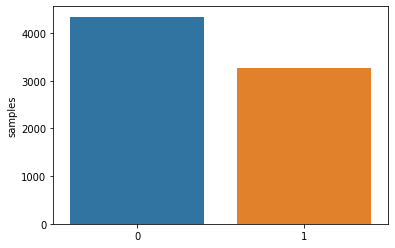

In [9]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

Um sich ein genaueres Bild von Disaster vs Non-Disaster Tweets zu machen, werden einige Eigenschaften von beiden Arten von Tweets gegenübergestellt.

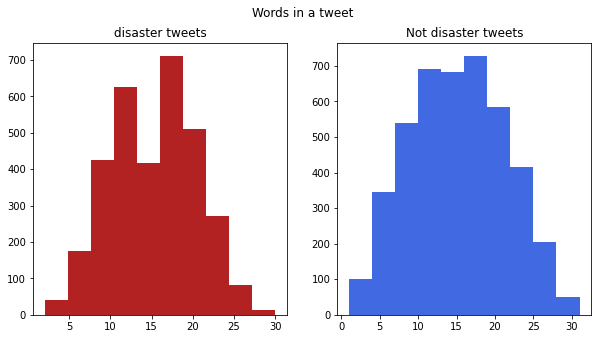

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='firebrick')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='royalblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

anhand der Wort Menge kann man erkennen, dass disaster Tweets tendenziell weniger Wörter beinhalten.

Text(0.5, 0.98, 'Average word length in each tweet')

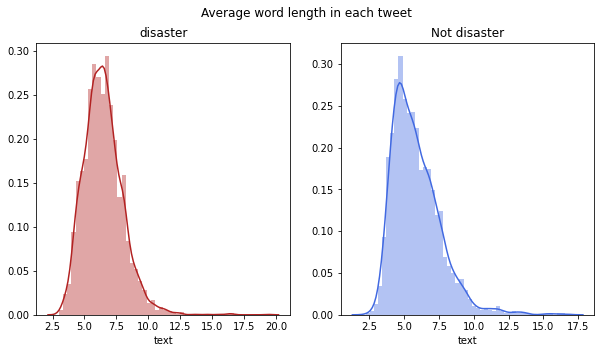

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='firebrick')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='royalblue')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

anhand der Wortlänge lässt sich kein signifikanter Unterschied erkennen.
Jedoch beinhalten disaster Tweets auf den ersten Blick etwas längere Wörter.

In [0]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [0]:
disaster = create_corpus(1)
non_disaster = create_corpus(0)

In [0]:
#print(disaster)

Überprüfe Anzahl an Hashtags pro Tweet

Text(0.5, 0.98, 'Number of Hashtags in each tweet')

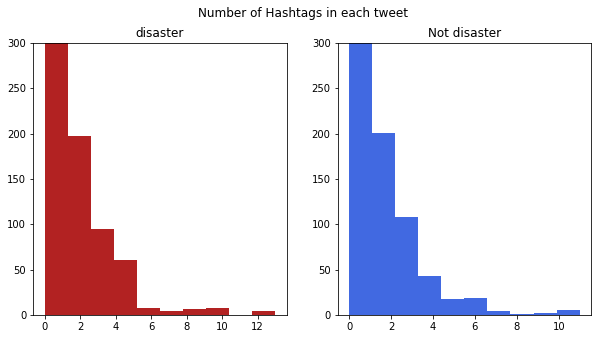

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
hashtags=train[train['target']==1]['text'].str.split().apply(lambda x : sum(i.startswith('#') for i in x))
ax1.hist(hashtags,color='firebrick')
ax1.set_ylim(0, 300)
ax1.set_title('disaster')
hashtags=train[train['target']==0]['text'].str.split().apply(lambda x : sum(i.startswith('#') for i in x))
ax2.hist(hashtags,color='royalblue')
ax2.set_ylim(0, 300)
ax2.set_title('Not disaster')
fig.suptitle('Number of Hashtags in each tweet')

viele Tweets haben keine Hashtags. Tendenziell haben disaster Tweets eher weniger Hashtags. Jedoch nicht signifikant.

Welches sind die am häufigsten verwendeten Wörter?

In [0]:
def common_words(corpus):
  counter=Counter(corpus)
  most=counter.most_common()
  x=[]
  y=[]
  for word,count in most[:40]:
      if (word not in stop) :
        x.append(word)
        y.append(count)

  return x, y

In [0]:
def plot_common_words(disaster, non_disaster):
  disaster_x, disaster_y = common_words(disaster)
  non_disaster_x, non_disaster_y = common_words(non_disaster)

  fig,(ax1,ax2)=plt.subplots(1,2,figsize=(40,10))
  ax1.barh(disaster_x, disaster_y)
  ax1.set_title('disaster')

  ax2.barh(non_disaster_x, non_disaster_y)
  ax2.set_title('non disaster')

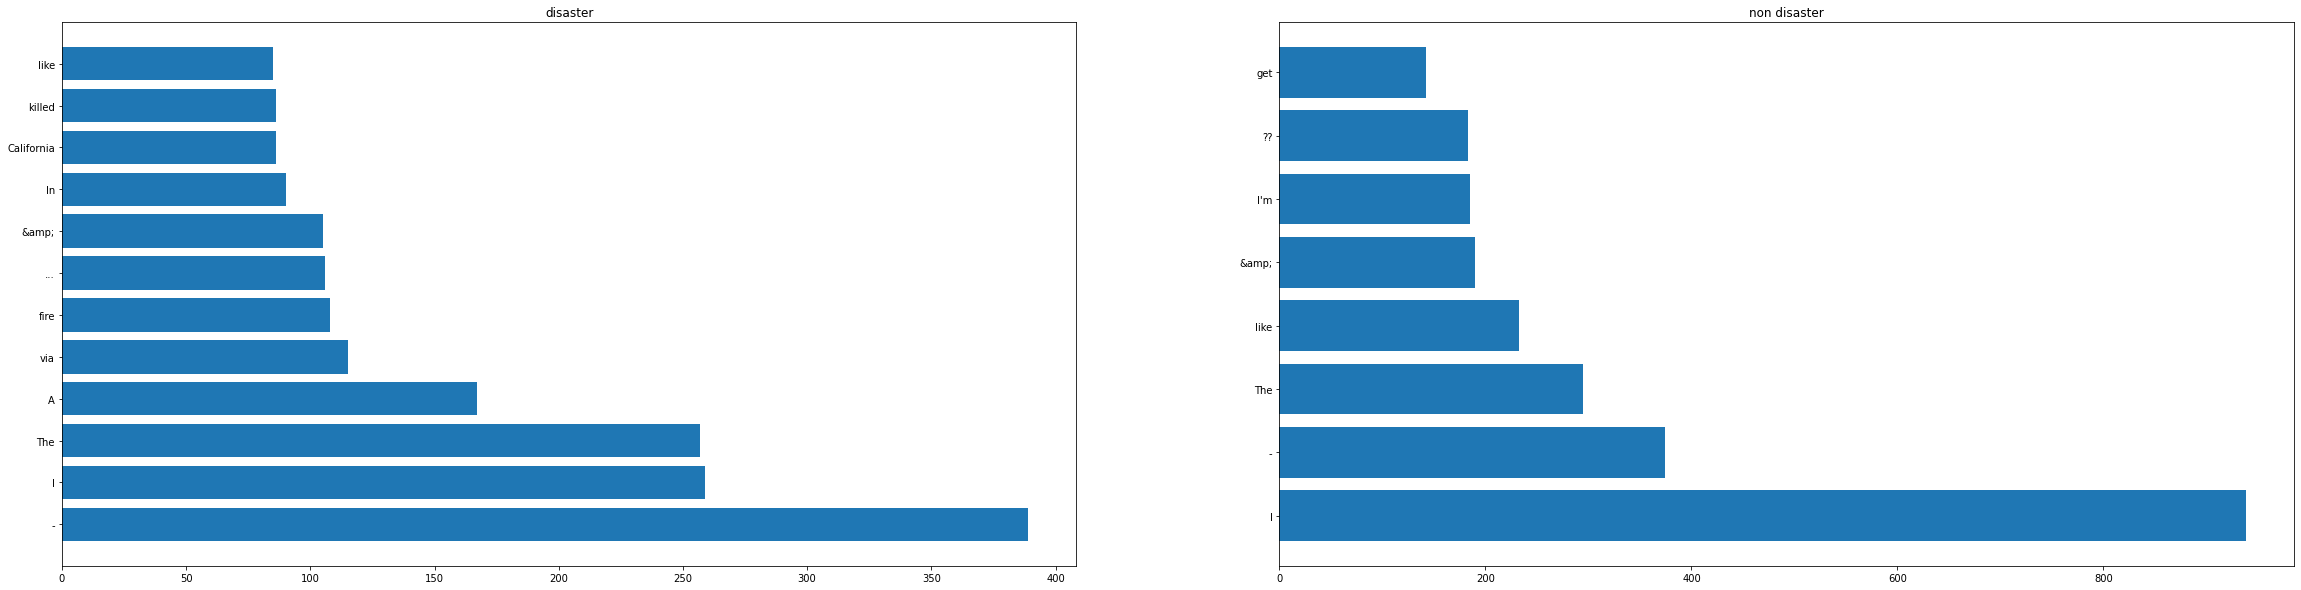

In [18]:
plot_common_words(disaster, non_disaster)

Hier schauen wir uns noch die keywords der Tweets, die am meisten verwendet wurden an.

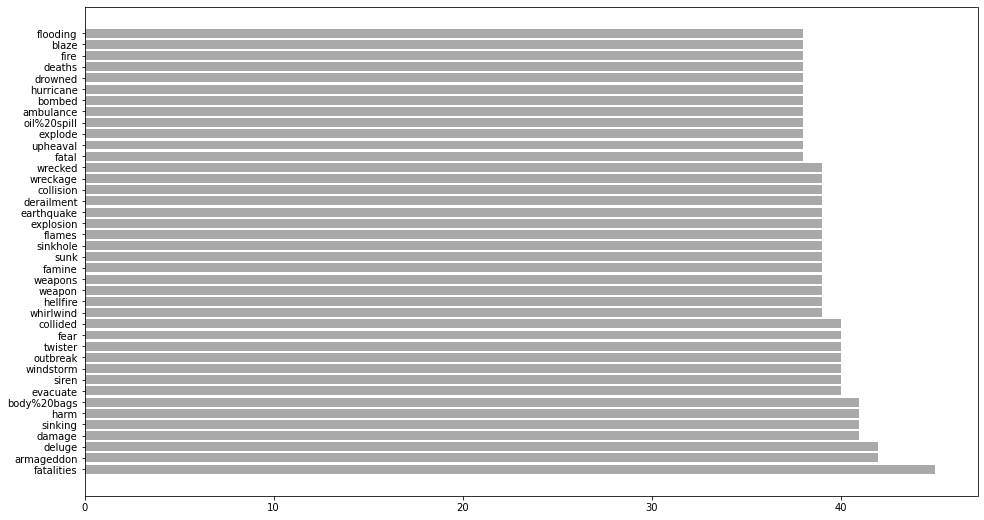

In [19]:
keywords=train['keyword'].value_counts()
fig, ax = plt.subplots(figsize =(16, 9))

keys = list(keywords.keys()[:40]) 
values = list(keywords[:40])
# Horizontal Bar Plot 
ax.barh(keys,values, color='darkgray') 
# Show Plot 
plt.show()

Zudem ist es interessant, an welchem Ort die meisten Tweets stattfanden.

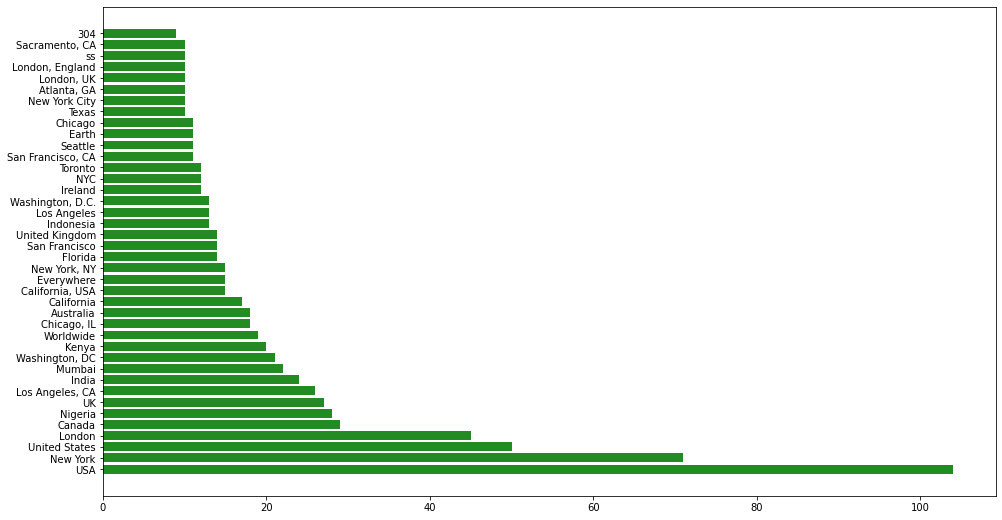

In [20]:
locations=train['location'].value_counts()
fig, ax = plt.subplots(figsize =(16, 9))

keys = list(locations.keys()[:40]) 
values = list(locations[:40])
# Horizontal Bar Plot 
ax.barh(keys,values, color='forestgreen') 
# Show Plot 
plt.show()

###Data Cleaning:

In [0]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [22]:
remove_punct(train.text[0])

'Our Deeds are the Reason of this earthquake May ALLAH Forgive us all'

In [23]:
remove_punct(train.text[15])

'Whats up man'

In [24]:
train.text[15]

"What's up man?"

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
#train.head(30)

In [0]:
def clean_stopwords(text):
    text  = "".join([word for word in text if word not in stop])
    return text

In [0]:
def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

In [0]:
def clean_non_alphabetic(text):
  text = ''.join([word for word in text if word.isalpha() or word == " "])   
  return text

In [0]:
def remove_stopwords(text):
  tokens = word_tokenize(str(text))

  text=""
  for t in tokens:
    if t not in stop:
      text = text + t + " "   
  return text

In [0]:
def clean_data(x):
  x= x.lower()
  x = remove_numbers(x)
  x = remove_URL(x)
  x = remove_punct(x)
  x = re.sub("§´", "",x)
  x = re.sub("'", " ", x)
  x = re.sub(r"&gt;", "", x)
  x = re.sub(r"&lt;", "", x)
  x = re.sub(r"&amp;", "", x)
  x = re.sub(r"\n", " ", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"\x89ûï", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"\x89û", "", x)
  x = re.sub(r"\x9d", "", x)
  x = re.sub('\w*\d\w*', '', x)
  x = re.sub('ì©', 'é', x)
  x = re.sub(r"åê", "", x)
  x = re.sub("  ", "",x)
  x = clean_non_alphabetic(x)
  x = remove_stopwords(x)
  return x

In [32]:
train['text']=train['text'].apply(lambda x: clean_data(x))
train['text'].values[:10]

array(['deeds reason earthquake may allah forgive us ',
       'forest fire near la ronge sask canada ',
       'residents asked shelter place notified officers evacuation shelter place orders expected ',
       'people receive wildfires evacuation orders california ',
       'got sent photo ruby alaska smoke wildfires pours school ',
       'rockyfire updatecalifornia hwyclosed directions due lake county firecafire wildfires ',
       'flood disaster heavy rain causes flash flooding streets manitou colorado springs areas ',
       'im top hill see fire woods ',
       'theres emergency evacuation happening building across street ',
       'im afraid tornado coming area '], dtype=object)

In [33]:
test['text']=test['text'].apply(lambda x: clean_data(x))
test['text'].values[:10]

array(['happened terrible car crash ',
       'heard earthquake different cities stay safe everyone ',
       'forest fire spot pond geese fleeing across street save ',
       'apocalypse lighting spokane wildfires ',
       'typhoon soudelor killsin china taiwan ', 'shakingits earthquake ',
       'theyd probably still show life arsenal yesterday eh eh ', 'hey ',
       'nice hat ', 'fuck '], dtype=object)

Die Tweets sind jetzt soweit bereinigt, dass sie keine Zeichen, Zahlen oder Zwischenwörter mehr enthalten, die mit dem eigentlichen Thema des Tweets nichts zu tun haben.

Jetzt geht es daran, ein Modell zu bauen, dass anhand dieser Tweets lernt, ob es sich um ein Disaster Tweet handelt oder nicht.

###Model Building:

Zunächst wird versucht mit Hilfe eines naive Bayes Klassifikators eine Lösung zu erzielen.

In [0]:
#from https://www.kaggle.com/mohitsital/0-80777-simplest-model-naive-bayes
from sklearn.feature_extraction.text import TfidfVectorizer

############ tf-idf ############################
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3)) # one,two and three gram vectorization
tf_idf_mat = tf_idf_vect.fit_transform(train['text'].values) # fit_transform vectorizer to train['text']
tf_idf_mat_test = tf_idf_vect.transform(test['text'].values) # fit_transform vectorizer to test['text']

In [35]:
 from sklearn.naive_bayes import MultinomialNB
 from sklearn.model_selection import train_test_split
 from sklearn.metrics import classification_report
 # applyig naive bayes , doing cross validation and accuracy matrix
target = train['target']

x, x_test, y, y_test = train_test_split(tf_idf_mat,target,test_size=0.2,train_size=0.8, random_state = 0)

naive_bayes_clf = MultinomialNB(alpha=1).fit(x, y)
predicted = naive_bayes_clf.predict(x_test)
 
# classification table
def printreport(exp, pred):
    print(pd.crosstab(exp, pred, rownames=['Actual'], colnames=['Predicted']))
    print('\n \n')
    print(classification_report(exp, pred))

printreport(y_test, predicted)

Predicted    0    1
Actual             
0          838   48
1          279  358

 

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       886
           1       0.88      0.56      0.69       637

    accuracy                           0.79      1523
   macro avg       0.82      0.75      0.76      1523
weighted avg       0.81      0.79      0.77      1523



In [0]:
nbPredictions = naive_bayes_clf.predict(tf_idf_mat_test)

In [0]:
submission = pd.read_csv('/content/DataScienceProjekt/sample_submission.csv')
#submission['target']= nbPredictions
#submission.to_csv('submission.csv',index=False)

Kaggle Score der ersten Submission mit einem Naive Bayes: 0.78732

Platz auf dem Leaderboard zum Zeitpunkt der Submission: 1056

Das geht besser!

Deshalb wird nun versucht, mit einem Bert Model das Problem zu lösen.

In [38]:
%%time

max_seq_length = 120
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)  
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])


clf_output = sequence_output[:, 0, :]
out = Dense(1, activation='sigmoid')(clf_output)

CPU times: user 10.3 s, sys: 1.36 s, total: 11.7 s
Wall time: 13.1 s


In [0]:
FullTokenizer = bert.bert_tokenization.FullTokenizer

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [0]:
#from https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
train_input = bert_encode(train.text.values, tokenizer, max_len=max_seq_length)
test_input = bert_encode(test.text.values, tokenizer, max_len=max_seq_length)
train_labels = train.target.values

In [42]:
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 120)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.25,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=64
)

Train on 5709 samples, validate on 1904 samples
Epoch 1/3
 192/5709 [>.............................] - ETA: 1:48:52 - loss: 0.7195 - accuracy: 0.5000

In [0]:
plt.figure(figsize=(50,30))

#accuracy plot
plt.subplot(1,2,1)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#loss plot
plt.subplot(1,2,2)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [0]:
model.trainable=False
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.load_weights('model.h5')
bertPrediction = model.predict(test_input)

In [0]:
submission['target'] = bertPrediction.round().astype(int)
submission.to_csv('submission.csv', index=False)